In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import re

In [4]:
crime_data = pd.read_csv('../../data/raw/Crime/Crime_info.csv')

In [5]:
# Remove unnecessary rows
crime_data = crime_data[~crime_data['Local Government Area'].isin(
    ['Justice Institutions and Immigration Facilities', 'Unincorporated Vic', 'Total']
)]

In [6]:
# Remove unnecessary columns
crime_data_cleaned = crime_data.drop(columns=['Year ending', 'Police Region'])

# Pivot the DataFrame to have Local Government Area as rows and each year's incidents recorded as columns
crime_pivot = crime_data_cleaned.pivot_table(
    index='Local Government Area',   # Rows: Local Government Areas
    columns='Year',                  # Columns: Year
    values='Rate per 100,000 population',     # Values: Incidents Recorded
    aggfunc='sum'                    # Aggregating in case of multiple entries for the same LGA and year
).reset_index()


In [7]:
crime_pivot

Year,Local Government Area,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Alpine,2405.664172,2607.727779,2206.983526,2487.911402,3092.064476,3355.293397,3038.128513,2797.361838,2624.791382,2501.430246
1,Ararat,7385.778083,7484.035760,7706.002035,7496.823380,7704.004055,7501.258600,9182.379302,8071.100527,7489.514679,8671.402588
2,Ballarat,7710.954976,8728.502415,8730.376785,8269.831239,7405.281809,7801.513727,6332.816465,6524.381309,6962.255686,7761.059695
3,Banyule,5216.198211,5667.453922,5788.123737,5681.669174,5364.184156,5573.549051,4934.442961,4102.741177,4262.279903,4633.858403
4,Bass Coast,5817.166012,6045.302415,5715.436860,4985.727351,4759.615385,4585.365854,5155.500922,5120.417095,4998.946851,5127.500868
...,...,...,...,...,...,...,...,...,...,...,...
76,Wodonga,6271.830304,6401.496259,6200.259569,5705.206904,5750.403954,6632.916139,5591.686532,6109.891115,6093.594724,7196.536061
77,Wyndham,4681.149592,5263.250634,4953.368133,4225.905607,4195.445844,4828.188742,4283.178434,3890.135036,4255.647403,4292.900421
78,Yarra,10782.558411,11176.179301,11965.757701,11149.271235,11581.247928,11821.605181,11827.886496,9492.163824,9782.653313,10433.930171
79,Yarra Ranges,3423.929696,3695.901460,4106.677899,3494.509533,3633.500268,3892.343715,3876.229982,3153.041590,3008.305292,3053.251024


/opt/anaconda3/envs/myenv2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/myenv2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/myenv2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)


Forecasted Crime Rates for 2025, 2026, and 2027:
1970-01-01 00:00:00.000002025    4750.109729
1970-01-01 00:00:00.000002026    4786.479893
1970-01-01 00:00:00.000002027    4797.858591
Freq: ns, Name: predicted_mean, dtype: float64


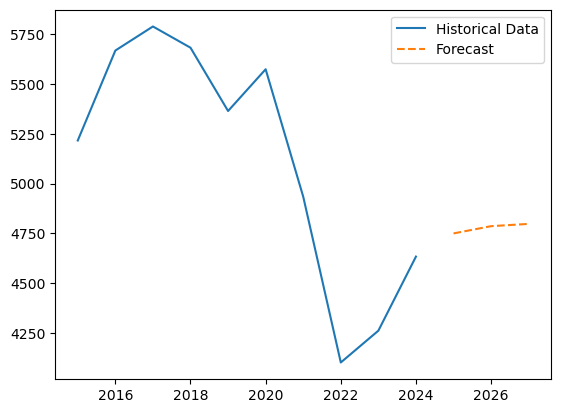

In [8]:
# Assuming you have your transformed dataframe with crime rates (pivoted) from 2015 to 2024
# Filter data for a single LGA or iterate through each one

lga_data = crime_pivot.set_index('Local Government Area').loc[' Banyule']  # Example: Banyule
lga_data = lga_data.dropna()

# Fit an ARIMA model (p,d,q) parameters can be tuned
model = ARIMA(lga_data, order=(1, 1, 0))
model_fit = model.fit()

# Forecast for 2025, 2026, 2027
forecast = model_fit.forecast(steps=3)

# Display forecasted values
print("Forecasted Crime Rates for 2025, 2026, and 2027:")
print(forecast)

# Plot the forecast
plt.plot(lga_data, label='Historical Data')
plt.plot(range(2025, 2028), forecast, label='Forecast', linestyle='--')
plt.legend()
plt.show()


Now apply it on all crime data

In [9]:
# Function to extract numerical part from ARIMA prediction
def extract_numeric(forecast_series):
    return np.array([float(re.search(r'[-+]?\d*\.\d+|\d+', str(f)).group()) for f in forecast_series])

# DataFrame to store the results
forecast_results = pd.DataFrame(columns=['Local Government Area', '2024', '2025', '2026', '2027'])

# Iterate over each Local Government Area (LGA)
for lga_name in crime_pivot['Local Government Area'].unique():
    # Prepare the data for ARIMA model (from 2015 to 2024)
    lga_data = crime_pivot.set_index('Local Government Area').loc[lga_name]
    lga_data = lga_data.dropna()
    # Fit the ARIMA model 
    arima_model = ARIMA(lga_data, order=(1, 1, 0))
    arima_model_fit = arima_model.fit()

    # Forecast values for 2025 to 2027
    arima_forecast = arima_model_fit.forecast(steps=3)
    arima_forecast_values = extract_numeric(arima_forecast)
    # Store the result in the DataFrame using pd.concat
    result_row = pd.DataFrame({
        'Local Government Area': [lga_name],
        '2024': [lga_data.loc[2024]],
        '2025': [arima_forecast_values[0]],
        '2026': [arima_forecast_values[1]],
        '2027': [arima_forecast_values[2]]
    })
    forecast_results = pd.concat([forecast_results, result_row], ignore_index=True)


# Save the forecast results to the specified path
output_path = '../../data/raw/ABS_population/crime_forecast_2024_2027.csv'
forecast_results.to_csv(output_path, index=False)


/opt/anaconda3/envs/myenv2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/myenv2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/myenv2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)
/var/folders/gv/pbj7gd456sj494dw3tvm283r0000gn/T/ipykernel_95480/2495932636.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant ent

In [10]:
forecast_results

,Local Government Area,2024,2025,2026,2027
0,Alpine,2501.430246,2472.826850,2466.194663,2464.656876
1,Ararat,8671.402588,8478.599199,8510.051545,8504.920670
2,Ballarat,7761.059695,7919.863535,7951.434057,7957.710340
3,Banyule,4633.858403,4750.109729,4786.479893,4797.858591
4,Bass Coast,5127.500868,5158.036806,5165.290127,5167.013037
...,...,...,...,...,...
76,Wodonga,7196.536061,6963.146007,7012.532965,7002.082341
77,Wyndham,4292.900421,4296.944727,4297.383789,4297.431455
78,Yarra,10433.930171,10451.457404,10451.929099,10451.941793
79,Yarra Ranges,3053.251024,3054.317946,3054.343272,3054.343874
